In [1]:
#!/usr/bin/env python

# Claculate_MCS_Characteristics_SouthAmerica.ipynb

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm
import xarray as xr
import geopandas as gpd
from tqdm import tqdm


In [3]:
def calc_grid_distance_area(lat,lon):
    """ Function to calculate grid parameters
        It uses haversine function to approximate distances
        It approximates the first row and column to the sencond
        because coordinates of grid cell center are assumed
        lat, lon: input coordinates(degrees) 2D [y,x] dimensions
        dx: distance (m)
        dy: distance (m)
        area: area of grid cell (m2)
        grid_distance: average grid distance over the domain (m)
    """
    dy = np.zeros(lat.shape)
    dx = np.zeros(lon.shape)

    dx[:,1:]=haversine(lat[:,1:],lon[:,1:],lat[:,:-1],lon[:,:-1])
    dy[1:,:]=haversine(lat[1:,:],lon[1:,:],lat[:-1,:],lon[:-1,:])

    dx[:,0] = dx[:,1]
    dy[0,:] = dy[1,:]

    area = dx*dy
    grid_distance = np.mean(np.append(dy[:, :, None], dx[:, :, None], axis=2))

    return dx,dy,area,grid_distance

In [44]:
def calc_grid_distance_area(lat,lon):
    """ Function to calculate grid parameters
        It uses haversine function to approximate distances
        It approximates the first row and column to the sencond
        because coordinates of grid cell center are assumed
        lat, lon: input coordinates(degrees) 2D [y,x] dimensions
        dx: distance (m)
        dy: distance (m)
        area: area of grid cell (m2)
        grid_distance: average grid distance over the domain (m)
    """
    dy = np.zeros(lat.shape)
    dx = np.zeros(lon.shape)

    dx[:,1:]=haversine(lat[:,1:],lon[:,1:],lat[:,:-1],lon[:,:-1])
    dy[1:,:]=haversine(lat[1:,:],lon[1:,:],lat[:-1,:],lon[:-1,:])

    dx[:,0] = dx[:,1]
    dy[0,:] = dy[1,:]

    area = dx*dy
    grid_distance = np.mean(np.append(dy[:, :, None], dx[:, :, None], axis=2))

    return dx,dy,area,grid_distance

In [4]:
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# https://stackoverflow.com/questions/46893369/count-unique-elements-along-an-axis-of-a-numpy-array
def nunique_axis0_maskcount_app1(A):
    m,n = A.shape[1:]
    mask = np.zeros((A.max()+1,m,n),dtype=bool)
    mask[A,np.arange(m)[:,None],np.arange(n)] = 1
    return mask.sum(0)

###  USER INPUT SECTION

In [6]:
FocMon=[1,2,3,4,5,6,7,8,9,10,11,12]

rgsDataSets_all = ['OBS','WRF']
WaterYear_all = ['WY2011', 'WY2016', 'WY2019']
rgsDataSetsNames=['Observation','WRF 4km']
Trackers = ['Julia'] #['Andreas', 'Julia','Amanda', 'Kelly-Zach', 'Zhe','TOOCAN']


sStat='seasons'
rgsSeas=['DJF','MAM','JJA','SON']
pr_threshold = 2 # mm/h

data_dir = '/glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/'
data_out_dir = '/glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/MCS_characteristics/'

### Read in the constant fields

In [7]:
# IMERGE
FocusRegion = [20, -30, -60, -85] #  N, E, S, W

dT = 1                    # temporal resolution of data for tracking in hours
MCS_min_time = 4
obj_structure_3D = np.ones((3,3,3))

In [17]:
for da in range(len(rgsDataSets_all)):
    rgsDataSets = rgsDataSets_all[da]
    print('PROCESS '+rgsDataSets)
    for wy in range(len(WaterYear_all)):
        WaterYear = WaterYear_all[wy]

        ### SET DATA SPECIFIC VARIABLES   
        if WaterYear == 'WY2011':
            StartDay = datetime.datetime(2010, 6, 1,0)
            StopDay = datetime.datetime(2011, 5, 31,23)    
        elif WaterYear == 'WY2016':
            StartDay = datetime.datetime(2015, 6, 1,0)
            StopDay = datetime.datetime(2016, 5, 31,23)    
        elif WaterYear == 'WY2019':
            StartDay = datetime.datetime(2018, 6, 1,0)
            StopDay = datetime.datetime(2019, 5, 31,23)

        # ===============================================
        # Setup variables for computation

        TimeHH=pd.date_range(StartDay, end=StopDay, freq='h')
        TimeMM=pd.date_range(StartDay, end=StopDay + datetime.timedelta(days=1), freq='m')
        TimeDD = pd.date_range(StartDay, end=StopDay, freq='d')
        TimeBT = pd.date_range(StartDay, end=StopDay, freq='h')
        Time = pd.date_range(StartDay, end=StopDay, freq=str(dT)+'h')
        Years = np.unique(TimeMM.year)
        iHHall = np.array(range(len(TimeHH)))

        # # ### Read the target grid
        ncid=Dataset('/glade/campaign/mmm/c3we/prein/SouthAmerica/MCS-Tracking/GPM/2001/merg_2001123110_4km-pixel.nc', mode='r')
        Lat=np.squeeze(ncid.variables['lat'][:])
        Lon=np.squeeze(ncid.variables['lon'][:])
        ncid.close()
        Lon,Lat = np.meshgrid(Lon,Lat)

        _,_,grid_cell_area,grid_spacing = calc_grid_distance_area(Lon,Lat)
        grid_cell_area[grid_cell_area < 0] = 0

        if Lon.max() > 180:
            Lon[Lon > 180] = Lon[Lon > 180]-360

        if (FocusRegion[1] > 0) & (FocusRegion[3] < 0):
            # region crosses zero meridian
            iRoll = np.sum(Lon[0,:] < 0)
        else:
            iRoll=0
        Lon = np.roll(Lon,iRoll, axis=1)

        iNorth = np.argmin(np.abs(Lat[:,0] - FocusRegion[0]))+1
        iSouth = np.argmin(np.abs(Lat[:,0] - FocusRegion[2]))
        iEast = np.argmin(np.abs(Lon[0,:] - FocusRegion[1]))+1
        iWest = np.argmin(np.abs(Lon[0,:] - FocusRegion[3]))
        print(iNorth,iSouth,iWest,iEast)

        Lon = Lon[iSouth:iNorth,iWest:iEast]
        Lat = Lat[iSouth:iNorth,iWest:iEast]

        Mask = np.copy(Lon); Mask[:]=1

        ## Load the precipitation data
        DATA_PR = np.zeros((len(Time),Lon.shape[0],Lon.shape[1])); DATA_PR[:] = np.nan
        if rgsDataSets == 'OBS':
            pr_data_dir = '/glade/campaign/mmm/c3we/prein/SouthAmerica/MCS-Tracking/GPM/'
            for hh in tqdm(range(len(TimeHH))):
                YYYY = str(TimeHH[hh].year)
                MM = str(TimeHH[hh].month).zfill(2)
                DD = str(TimeHH[hh].day).zfill(2)
                HH = str(TimeHH[hh].hour).zfill(2)
                file_dir = pr_data_dir + YYYY + '/merg_' + YYYY + MM + DD + HH + '_4km-pixel.nc'
                ncid=Dataset(file_dir, mode='r')
                DATA_PR [hh,:,:] =np.squeeze(ncid.variables['precipitationCal'][0,:])
                ncid.close()
        if rgsDataSets == 'WRF':
            pr_data_dir = '/glade/campaign/mmm/c3we/prein/SouthAmerica/MCS-Tracking/WY' +str(TimeHH[0].year + 1)+'/WRF/'
            for hh in tqdm(range(len(TimeHH))):
                YYYY = str(TimeHH[hh].year)
                MM = str(TimeHH[hh].month).zfill(2)
                DD = str(TimeHH[hh].day).zfill(2)
                HH = str(TimeHH[hh].hour).zfill(2)
                file_dir = pr_data_dir + '/tb_rainrate_'+YYYY+'-'+MM+'-'+DD+'_'+HH+':00.nc'
                ncid=Dataset(file_dir, mode='r')
                DATA_PR [hh,:,:] =np.squeeze(ncid.variables['rainrate'][0,:])
                ncid.close()

        ### Read MCS mask files and calculate MCS statistics
        for tr in range(len(Trackers)):
            outfile = data_out_dir+Trackers[tr]+'_' + rgsDataSets + '_MCS_WY' +str(TimeHH[0].year + 1) + '.pkl'
            if os.path.isfile(outfile+'*') == 0:
                print('    --- work on '+Trackers[tr] + ' ----')

                mcs_mask = np.zeros((len(Time),Lon.shape[0],Lon.shape[1])); mcs_mask[:] = np.nan
                if Trackers[tr] == 'Andreas':
                    file = data_dir + Trackers[tr] + '/prein_WY' +str(TimeHH[0].year + 1)+ '_' +rgsDataSets+ '_SAAG-MCS-mask-file.nc'
                    ncid=Dataset(file, mode='r')
                    mcs_mask[:,:,:] =np.squeeze(ncid.variables['mcs_mask'][:])
                    ncid.close()
                if Trackers[tr] == 'Julia':
                    for mm in range(len(TimeMM)):
                        time_loc = np.isin(TimeHH.month, TimeMM[mm].month)
                        file = data_dir + Trackers[tr] + '/kukulies_WY' +str(TimeHH[0].year + 1)+ '-'+str(TimeMM[mm].month).zfill(2)+'_' +rgsDataSets+ '_SAAG-MCS-mask-file.nc'
                        ncid=Dataset(file, mode='r')
                        mask_mm = np.squeeze(ncid.variables['mcs_mask'][:])
                        ncid.close()
                        mask_mm[mask_mm > 0] = mask_mm[mask_mm > 0] + int((TimeMM[mm].month)*10000)
                        mcs_mask[time_loc,:,:] = mask_mm
                if Trackers[tr] == 'Amanda':
                    file = data_dir + Trackers[tr] + '/Rehbein_WY' +str(TimeHH[0].year + 1)+ '_' +rgsDataSets+ '_SAAG-MCS-mask-file.nc'
                    ds_disk = xr.open_dataset(file)
                    time_amanda = pd.to_datetime(ds_disk['time'].values)
                    mcs_mask_amanda = ds_disk['mcs_mask'].values
                    mcs_mask_amanda[np.isnan(mcs_mask_amanda)] = 0
                    time_sel = np.isin(time_amanda, Time)
                    time_sel_fin = np.isin(Time, time_amanda)
                    mcs_mask[time_sel_fin,:,:] = mcs_mask_amanda[time_sel,:]
                if Trackers[tr] == 'Kelly-Zach':
                    file = data_dir + Trackers[tr] + '/TAMS_WY' +str(TimeHH[0].year + 1)+ '_' +rgsDataSets+ '_SAAG-MCS-mask-file.nc'
                    if os.path.isfile(file) == True:
                        ds_disk = xr.open_dataset(file)
                        time_nc = pd.to_datetime(ds_disk['time'].values)
                        mcs_mask_nc = ds_disk['mcs_mask'].values
                        time_axis = np.where(time_nc.shape[0] == np.array(mcs_mask_nc.shape))[0][0]
                        if time_axis !=0:
                            mcs_mask_nc = np.moveaxis(mcs_mask_nc, time_axis, 0)
                        mcs_mask_nc[np.isnan(mcs_mask_nc)] = 0
                        time_sel = np.isin(time_nc, Time)
                        time_sel_fin = np.isin(Time, time_nc)
                        mcs_mask[time_sel_fin,:,:] = mcs_mask_nc[time_sel,:]
                    else:
                        print('    File does not exist - '+file)
                if Trackers[tr] == 'Zhe':
                    from datetime import timedelta
                    file = data_dir + Trackers[tr] + '/feng_WY' +str(TimeHH[0].year + 1)+ '_' +rgsDataSets+ '_SAAG-MCS-mask-file.nc'
                    ds_disk = xr.open_dataset(file)
                    time_nc = pd.to_datetime(ds_disk['time'].values)
                    if rgsDataSets == 'OBS':
                        time_nc = pd.Series(time_nc - timedelta(hours=0, minutes=30)).dt.round("s")
                    mcs_mask_nc = ds_disk['mcs_mask'].values
                    mcs_mask_nc[np.isnan(mcs_mask_nc)] = 0
                    time_sel = np.isin(time_nc, Time)
                    time_sel_fin = np.isin(Time, time_nc)
                    mcs_mask[time_sel_fin,:,:] = mcs_mask_nc[time_sel,:]
                if Trackers[tr] == 'TOOCAN':
                    file = data_dir + Trackers[tr] + '/TOOCAN_WY' +str(TimeHH[0].year + 1)+ '_' +rgsDataSets+ '_SAAG-MCS-mask-file.nc'
                    if os.path.isfile(file) == False:
                        continue
                    ncid=Dataset(file, mode='r')
                    mcs_mask[:,:,:] =np.squeeze(ncid.variables['mcs_mask'][:])
                    ncid.close()

                print('        calculate MCS characteristics')
#                 objects_id_mcs, num_objects = ndimage.label(mcs_mask, structure=obj_structure_3D)
                objects_id_mcs = mcs_mask.astype(int)
                objects_id_mcs[objects_id_mcs < 0] = 0


                # CALCULATE OBJECT CHARACTERISTICS
                var_objects = objects_id_mcs # feature object file
                var_data = DATA_PR  # original file used for feature detection
                filename_out = outfile  # output file name and locaiton
                times = TimeHH  # timesteps of the data
                Lat = Lat  # 2D latidudes
                Lon = Lon  # 2D Longitudes
                grid_spacing = grid_spacing  # average grid spacing
                grid_cell_area = grid_cell_area
                min_tsteps = int(MCS_min_time / dT)
                
                import scipy
                import pickle

                num_objects = int(var_objects.max())
            #     num_objects = len(np.unique(var_objects))-1
                object_indices = ndimage.find_objects(var_objects)
                # remove elements that did not have an element and were assigned a None
                elements = np.unique(var_objects)
                elements = elements[elements > 0]
                object_indices = np.array(object_indices)[np.where(~np.isin(np.array(range(1,np.max(elements)+1,1)), elements) == False)]

                if num_objects >= 1:
                    objects_charac = {}
                    print("            Loop over " + str(num_objects) + " objects")
#                     mcs_index = np.unique(var_objects)[1:]
                    ii = 0
                    for iobj in tqdm(elements):
#                         if iobj == 22048:
#                             stop()
                        object_slice = np.copy(var_objects[tuple(object_indices[ii])])
                        if np.isin(iobj, np.unique(var_objects[tuple(object_indices[ii])])) == False:
                            stop()
#                         orig_obj_id = np.copy(mcs_mask[object_indices[ii]])
#                         orig_obj_id[object_slice!=(iobj)] = np.nan
#                         orig_obj_id = int(np.unique(orig_obj_id[:,:,:])[0])
                        data_slice   = np.copy(var_data[tuple(object_indices[ii])])
                        time_idx_slice = tuple(object_indices[ii])[0]
                        lat_idx_slice  = tuple(object_indices[ii])[1]
                        lon_idx_slice  = tuple(object_indices[ii])[2]

#                         if len(object_slice) >= min_tsteps:
                        data_slice[object_slice!=(iobj)] = np.nan
                        data_slice[data_slice < pr_threshold] = np.nan
                        stop()
                        grid_cell_area_slice = np.tile(grid_cell_area[lat_idx_slice, lon_idx_slice], (len(data_slice), 1, 1))
                        grid_cell_area_slice[object_slice != (iobj)] = np.nan
                        lat_slice = Lat[lat_idx_slice, lon_idx_slice]
                        lon_slice = Lon[lat_idx_slice, lon_idx_slice]

                        # calculate statistics
                        obj_times = times[time_idx_slice]
                        obj_size  = np.nansum(grid_cell_area_slice, axis=(1, 2))
                        obj_min = np.nanmin(data_slice, axis=(1, 2))
                        obj_max = np.nanmax(data_slice, axis=(1, 2))
                        obj_95P = np.nanpercentile(data_slice, 95 ,axis=(1, 2))
                        obj_mean = np.nanmean(data_slice, axis=(1, 2))
                        obj_tot = np.nansum(data_slice * grid_cell_area_slice, axis=(1, 2))
                        data_slice[data_slice < 10] = np.nan
                        obj_tot_gt10 = np.nansum(data_slice * grid_cell_area_slice, axis=(1, 2))

                        # Track lat/lon
                        obj_mass_center = \
                        np.array([ndimage.measurements.center_of_mass(object_slice[tt,:,:]==(iobj)) for tt in range(object_slice.shape[0])])

                        obj_track = np.full([len(obj_mass_center), 2], np.nan)
                        iREAL = ~np.isnan(obj_mass_center[:,0])
                        try:
                            obj_track[iREAL,0]=np.array([lat_slice[int(round(obj_loc[0])),int(round(obj_loc[1]))] for tstep, obj_loc in enumerate(obj_mass_center[iREAL,:]) if np.isnan(obj_loc[0]) != True])
                            obj_track[iREAL,1]=np.array([lon_slice[int(round(obj_loc[0])),int(round(obj_loc[1]))] for tstep, obj_loc in enumerate(obj_mass_center[iREAL,:]) if np.isnan(obj_loc[0]) != True])
                        except:
                            stop()


        #                 obj_track = np.full([len(obj_mass_center), 2], np.nan)
        #                 try:
        #                     obj_track[:,0]=np.array([lat_slice[int(round(obj_loc[0])),int(round(obj_loc[1]))]    for tstep, obj_loc in enumerate(obj_mass_center[:,:]) if np.isnan(obj_loc[0]) != True])
        #                     obj_track[:,1]=np.array([lon_slice[int(round(obj_loc[0])),int(round(obj_loc[1]))]    for tstep, obj_loc in enumerate(obj_mass_center[:,:]) if np.isnan(obj_loc[0]) != True])
        #                 except:
        #                     stop()

        #                 if np.any(np.isnan(obj_track)):
        #                     raise ValueError("track array contains NaNs")

                        obj_speed = (np.sum(np.diff(obj_mass_center,axis=0)**2,axis=1)**0.5) * (grid_spacing / 1000.0)

                        this_object_charac = {
                            "mass_center_loc": obj_mass_center,
                            "speed": obj_speed,
                            "tot": obj_tot,
                            "min": obj_min,
                            "max": obj_max,
                            "mean": obj_mean,
                            "size": obj_size,
                            #                        'rgrAccumulation':rgrAccumulation,
                            "P95pr": obj_95P,
                            "tot_vs_gt10": obj_tot_gt10,
                            "times": obj_times,
                            "track": obj_track,
                        }
                        try:
                            objects_charac[str(iobj)] = this_object_charac
                        except:
                            raise ValueError ("Error asigning properties to final dictionary")
                        ii += 1

                    if filename_out is not None:
                        with open(filename_out, 'wb') as handle:
                            pickle.dump(objects_charac, handle)

                    grMCSs = objects_charac

                # calculate monthly mean total and MCS rainfall
                DATA_PR_mm = np.array([
                    np.mean(DATA_PR[TimeHH.month == mm,:], axis=0) for mm in TimeMM.month
                ])
                DATA_PR_mm_mcs = np.copy(DATA_PR)
                DATA_PR_mm_mcs[objects_id_mcs == 0] = 0
                DATA_PR_mm_mcs = np.array([
                    np.mean(DATA_PR_mm_mcs[TimeHH.month == mm,:], axis=0) for mm in TimeMM.month
                ])
                
                # Calculate frequency of objects
                object_frequency = np.array([
                    np.sum(objects_id_mcs[TimeHH.month == mm,:] > 0, axis=0) for mm in TimeMM.month
                ])
                
                # Unique MCSs in each grid cell
                object_frequency_unique = np.array([
                    nunique_axis0_maskcount_app1(objects_id_mcs[TimeHH.month == mm,:]) for mm in TimeMM.month
                ])
                
                np.savez(data_out_dir+Trackers[tr]+'_' + rgsDataSets + 
                        '_MCS-PR-contribution_WY' +str(TimeHH[0].year + 1)+'.npz',
                       Lon = Lon,
                       Lat = Lat,
                       TimeMM = TimeMM,
                       DATA_PR_mm = DATA_PR_mm,
                       DATA_PR_mm_mcs = DATA_PR_mm_mcs,
                       object_frequency = object_frequency,
                       object_frequency_unique = object_frequency_unique
                       )
                stop()
            else:
                print('    skip '+outfile)

PROCESS OBS
690 0 0 480


100%|██████████| 8760/8760 [05:57<00:00, 24.48it/s]


    --- work on Julia ----
        calculate MCS characteristics


/glade/scratch/prein/ipykernel_232574/2714350775.py:176: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  object_indices = np.array(object_indices)[np.where(~np.isin(np.array(range(1,np.max(elements)+1,1)), elements) == False)]


            Loop over 123200 objects


  0%|          | 0/7344 [00:00<?, ?it/s]

> /glade/scratch/prein/ipykernel_232574/2714350775.py(201)<cell line: 1>()
    199                         data_slice[data_slice < pr_threshold] = np.nan
    200                         stop()
--> 201                         grid_cell_area_slice = np.tile(grid_cell_area[lat_idx_slice, lon_idx_slice], (len(data_slice), 1, 1))
    202                         grid_cell_area_slice[object_slice != (iobj)] = np.nan
    203                         lat_slice = Lat[lat_idx_slice, lon_idx_slice]



ipdb>  grid_cell_area[lat_idx_slice, lon_idx_slice]


array([[116.51234211, 116.51234211, 116.51234211, ..., 116.51234211,
        116.51234211, 116.51234211],
       [116.58357691, 116.58357691, 116.58357691, ..., 116.58357691,
        116.58357691, 116.58357691],
       [116.65445658, 116.65445658, 116.65445658, ..., 116.65445658,
        116.65445658, 116.65445658],
       ...,
       [119.4731711 , 119.4731711 , 119.4731711 , ..., 119.4731711 ,
        119.4731711 , 119.4731711 ],
       [119.52749887, 119.52749887, 119.52749887, ..., 119.52749887,
        119.52749887, 119.52749887],
       [119.58146254, 119.58146254, 119.58146254, ..., 119.58146254,
        119.58146254, 119.58146254]])


ipdb>  exit


  0%|          | 0/7344 [14:57<?, ?it/s]


In [19]:
grid_cell_area_slice = np.tile(grid_cell_area[lat_idx_slice, lon_idx_slice], (len(data_slice), 1, 1))
grid_cell_area_slice[object_slice != (iobj)] = np.nan

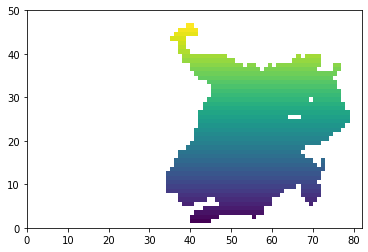

In [23]:
plt.pcolormesh(grid_cell_area_slice[3,:,:])

In [31]:
np.nansum(grid_cell_area_slice, axis=(1, 2)).min()

68894.33370054279

In [ ]:
[np.mean(objects_charac[list(objects_charac.keys())[ii]]['size'])/1000**2 for ii in range(len(objects_charac.keys()))]

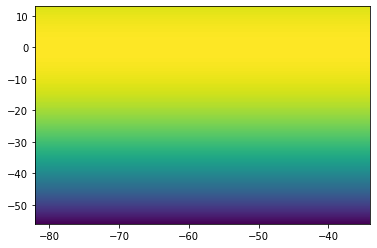

In [43]:
plt.pcolormesh(Lon,Lat,grid_cell_area)

In [32]:
Lon

masked_array(
  data=[[-81.95, -81.85, -81.75, ..., -34.25, -34.15, -34.05],
        [-81.95, -81.85, -81.75, ..., -34.25, -34.15, -34.05],
        [-81.95, -81.85, -81.75, ..., -34.25, -34.15, -34.05],
        ...,
        [-81.95, -81.85, -81.75, ..., -34.25, -34.15, -34.05],
        [-81.95, -81.85, -81.75, ..., -34.25, -34.15, -34.05],
        [-81.95, -81.85, -81.75, ..., -34.25, -34.15, -34.05]],
  mask=False,
  fill_value=1e+20)

In [33]:
Lat

masked_array(
  data=[[-55.95, -55.95, -55.95, ..., -55.95, -55.95, -55.95],
        [-55.85, -55.85, -55.85, ..., -55.85, -55.85, -55.85],
        [-55.75, -55.75, -55.75, ..., -55.75, -55.75, -55.75],
        ...,
        [ 12.75,  12.75,  12.75, ...,  12.75,  12.75,  12.75],
        [ 12.85,  12.85,  12.85, ...,  12.85,  12.85,  12.85],
        [ 12.95,  12.95,  12.95, ...,  12.95,  12.95,  12.95]],
  mask=False,
  fill_value=1e+20)

In [5]:
from Tracking_Functions import calc_grid_distance_area

In [20]:
ncid=Dataset('/glade/campaign/mmm/c3we/prein/SouthAmerica/MCS-Tracking/GPM/2001/merg_2001123110_4km-pixel.nc', mode='r')
Lat=np.squeeze(ncid.variables['lat'][:])
Lon=np.squeeze(ncid.variables['lon'][:])
ncid.close()
Lon,Lat = np.meshgrid(Lon,Lat)

In [21]:
_,_,grid_cell_area,grid_spacing = calc_grid_distance_area(Lon,Lat)
grid_cell_area[grid_cell_area < 0] = 0

In [23]:
grid_cell_area

array([[ 69.14286975,  69.14286975,  69.14286975, ...,  69.14286975,
         69.14286975,  69.14286975],
       [ 69.32133914,  69.32133914,  69.32133914, ...,  69.32133914,
         69.32133914,  69.32133914],
       [ 69.49959736,  69.49959736,  69.49959736, ...,  69.49959736,
         69.49959736,  69.49959736],
       ...,
       [120.44298244, 120.44298244, 120.44298243, ..., 120.44298243,
        120.44298243, 120.44298243],
       [120.39523273, 120.39523273, 120.39523273, ..., 120.39523273,
        120.39523273, 120.39523273],
       [120.34711629, 120.34711629, 120.34711629, ..., 120.34711629,
        120.34711629, 120.34711629]])

In [8]:
grid_spacing

8420.55884462646

In [16]:
def calc_grid_distance_area(lat,lon):
    """ Function to calculate grid parameters
        It uses haversine function to approximate distances
        It approximates the first row and column to the sencond
        because coordinates of grid cell center are assumed
        lat, lon: input coordinates(degrees) 2D [y,x] dimensions
        dx: distance (m)
        dy: distance (m)
        area: area of grid cell (m2)
        grid_distance: average grid distance over the domain (m)
    """
    dy = np.zeros(lat.shape)
    dx = np.zeros(lon.shape)

    dx[:,1:]=haversine(lat[:,1:],lon[:,1:],lat[:,:-1],lon[:,:-1])
    dy[1:,:]=haversine(lat[1:,:],lon[1:,:],lat[:-1,:],lon[:-1,:])

    dx[:,0] = dx[:,1]
    dy[0,:] = dy[1,:]

    area = dx*dy
    grid_distance = np.mean(np.append(dy[:, :, None], dx[:, :, None], axis=2))

    return dx,dy,area,grid_distance

In [13]:
def haversine(lat1, lon1, lat2, lon2):

    """Function to calculate grid distances lat-lon
       This uses the Haversine formula
       lat,lon : input coordinates (degrees) - array or float
       dist_m : distance (m)
       https://en.wikipedia.org/wiki/Haversine_formula
       """
    # convert decimal degrees to radians
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + \
    np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    # Radius of earth in kilometers is 6371
    dist_m = c * 6371000 #const.earth_radius
    return dist_m

In [19]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [ ]:
def haversine(lat1, lon1, lat2, lon2):

    """Function to calculate grid distances lat-lon
       This uses the Haversine formula
       lat,lon : input coordinates (degrees) - array or float
       dist_m : distance (m)
       https://en.wikipedia.org/wiki/Haversine_formula
       """
    # convert decimal degrees to radians
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + \
    np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    # Radius of earth in kilometers is 6371
    dist_m = c * 6371000 #const.earth_radius
    return dist_m